In [2]:
import os
import shutil
import vcf
import re
import gzip
import pandas as pd
import yaml
import subprocess
import matplotlib.pyplot as plt

from IPython.display import Image
from Bio import SeqIO


import rpy2.ipython


%load_ext rpy2.ipython

os.chdir("/master/nplatt/sch_man_nwinvasion")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Linkage Disequilibrium

In [3]:
if not os.path.isdir("results/ld"):
    os.mkdir("results/ld")

Read in population assignment and create (new) list files

In [4]:
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

for pop in set(pop_assign.values()):
    list_file = "results/ld/{}.list".format(pop);
    if os.path.exists(list_file):
        os.remove(list_file)

In [5]:
for pop in set(pop_assign.values()):
    list_file = "results/ld/{}.list".format(pop);
    if os.path.exists(list_file):
        os.remove(list_file)
    
for sample in pop_assign:
   
    pop=pop_assign[sample]
    list_file="results/ld/" + pop + ".list"
    with open(list_file, 'a') as filehandle:
        filehandle.write("{}\n".format(sample))

## Calculate R2 with VCFtools and Plink

In [ ]:
in_vcf="results/variant_filtration/smv7_ex_autosomes.vcf"

for pop in ["senegal", "niger", "brazil", "tanzania"]:
    in_list = "results/ld/{}.list".format(pop)
    
    for chrom in list(range(1, 8)):
        chrom="SM_V7_{}".format(chrom)
        out_vcf = "results/ld/smv7_ex_autosomes_{}_{}.vcf".format(pop, chrom)
        
        #get ld chrom vcf
        vcf_cmd="vcftools --vcf {} --mac 1 --chr {} --keep {} --recode --recode-INFO-all --stdout >{}".format(in_vcf, chrom, in_list, out_vcf)
        !{vcf_cmd}

        #convert vcf to plink
        plink_prefix="results/ld/smv7_ex_autosomes_{}_{}".format(pop, chrom)
        plink_cmd="plink --threads 6 --vcf {} --out {} --double-id --recode12 --allow-extra-chr".format(out_vcf, plink_prefix)
        !{plink_cmd}  
        
        #calculate R2 between all snps on a chr
        plink_cmd="plink --threads 6 --r2 --file {} --out {} --double-id --allow-extra-chr --ld-window-r2 0.0 --ld-window 1000000 --ld-window-kb 1000".format(plink_prefix, plink_prefix)
        !{plink_cmd}


Make new files that contain all R2 info from Plink, but also add distance between SNP-A and SNP-B. 

In [ ]:
#create tables
for pop in ["senegal", "niger", "brazil", "tanzania"]:
    print(pop)
    
    in_list = "results/ld/{}.list".format(pop)
    
    #open the outfile that will contain ALL of the data (and add a header)
    with open("results/ld/smv7_ex_autosomes_{}_dist.tbl".format(pop), 'w') as merged_all_out_file:
        #print header line
        header_line="chr_a\tbp_a\tsnp_a\tchr_b\tbp_b\tsnp_b\tr2\ta_b_dist\n"
        merged_all_out_file.write(header_line)
        
        #open each chrom specific ld file (and skip the header)
        for chrom in list(range(1, 8)):
            chrom="SM_V7_{}".format(chrom)
            plink_file="results/ld/smv7_ex_autosomes_{}_{}.ld".format(pop, chrom)

            with open(plink_file, 'r') as in_file:
                next(in_file)

                #for each r2 calc
                for entry in in_file:
                    entry=','.join(entry.split())
                    chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2 = entry.split(",")

                    #calculate the distance between the snps
                    a_b_dist = int(bp_b) - int(bp_a)
                    outline=[chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2, str(a_b_dist), "\n"]
                    outline="\t".join(outline)

                    #and print to the ALL output file
                    merged_all_out_file.write(outline)

In [ ]:
#clean up all of the unused files
for pop in ["senegal", "niger", "brazil", "tanzania"]:
    for chrom in list(range(1, 8)):
        chrom="SM_V7_{}".format(chrom)
        for ext in ["ld", "map", "ped", "log", "nosex", "vcf"]:
            file_to_del="results/ld/smv7_ex_autosomes_{}_{}.{}".format(pop, chrom, ext)
            if os.path.exists(file_to_del):
                os.remove(file_to_del)

## Bin and Smooth mean R2 values (in R)

In [6]:
%%R
#in R generate summary stats for bins and plot

library(fields)

#500bp bins for 1Mb
breaks <- seq( 0, 1e6, 500)

centers   <- vector()
means     <- vector()
pops      <- vector()
smootheds <- vector()

for (pop in c("senegal", "tanzania", "brazil", "niger")) {
    print(pop)
    
    #read in lt r2 table from plink
    ld_table <- read.table(paste("results/ld/smv7_ex_autosomes_", pop, "_dist.tbl", sep=""), 
                           header=TRUE)
    
    #bin r2 values and calculate stats
    ld_binned <- stats.bin(ld_table$a_b_dist, ld_table$r2, breaks = breaks)
    
    #created regression line
    loessMod  <- loess(ld_binned$stats["mean",] ~ ld_binned$centers, span=0.50)
    smoothed  <- predict(loessMod)
    
    #append all data to vectors
    centers   <- append(centers, ld_binned$centers)
    means     <- append(means, ld_binned$stats["mean",])
    pops      <- append(pops, rep(pop, length(ld_binned$centers)))
    smootheds <- append(smootheds, smoothed)
}    

#build the dataframe and save to csv
r2_df <- data.frame(centers, means, pops, smootheds)
write.csv(r2_df, file = paste("results/ld/ld_dist_binned_smoothed.csv", sep="") ,row.names=FALSE)

R[write to console]: Loading required package: spam

R[write to console]: Loading required package: dotCall64

R[write to console]: Loading required package: grid

R[write to console]: Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

R[write to console]: 
Attaching package: ‘spam’


R[write to console]: The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


R[write to console]: See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "senegal"
[1] "tanzania"
[1] "brazil"
[1] "niger"


In [7]:
#confert to a proper table (with the far superior power of python)
df = pd.read_csv ('results/ld/ld_dist_binned_smoothed.csv')
df = df.pivot(index='pops', columns='centers', values='smootheds')
df = df.transpose()

csv_file = "results/ld/ld_dist_binned_smoothed_table.csv"
df.to_csv(csv_file, index=False, header=True, mode='w')

In [8]:
df

pops,brazil,niger,senegal,tanzania
centers,,,,
250,0.413249,0.504390,0.342691,0.101258
750,0.412220,0.503355,0.341727,0.100974
1250,0.411192,0.502322,0.340764,0.100690
1750,0.410166,0.501290,0.339802,0.100406
2250,0.409141,0.500259,0.338842,0.100123
...,...,...,...,...
997750,0.033349,0.174874,0.066078,0.028996
998250,0.033347,0.174819,0.066045,0.028998
998750,0.033345,0.174764,0.066012,0.028999


## Plot the results

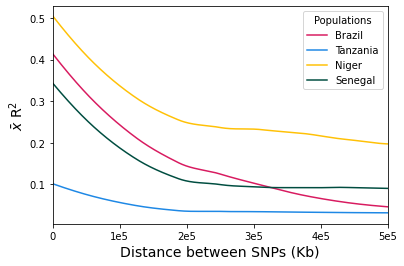

In [45]:
x=list(df.index)

plt.plot(x, df["brazil"],   c="#D81B60",   label="Brazil")
plt.plot(x, df["tanzania"], c="#1E88E5",  label="Tanzania")
plt.plot(x, df["niger"],    c="#FFC107", label="Niger")
plt.plot(x, df["senegal"],  c="#004D40", label="Senegal")

plt.xlim(0, 5e5)
plt.xticks(ticks=[0, 1e5, 2e5, 3e5, 4e5, 5e5], labels=["0", "1e5", "2e5", "3e5", "4e5", "5e5"])
plt.xlabel("Distance between SNPs (Kb)", fontsize=14)

plt.ylabel(r'$\bar{x}$ R$^2$', fontsize=14)


plt.legend(title="Populations")

plt.savefig("results/ld/ld_decay.svg")
plt.savefig("results/ld/ld_decay.png")

plt.show()